# HomeWork #6

Завдання 1 <br>
У цьому завданні вам потрібно завантажити ось цей датасет. Тут ви знайдете 2 файли - з двовимірним датасетом та датасетом mnist. Для кожного з них застосуйте алгоритм K-means для кластеризації. Щоб знайти оптимальну кількість кластерів, скористайтесь ліктєвим методом.<br><br>
Завдання 2<br>
Візуалізуйте результат роботи кластеризації. Для випадку з mnist датасетом, вам потрібно ще скористатись алгоримтом PCA щоб зменшити розмірність ваших даних до 2-вимірного варіанту.<br>

In [508]:
from itertools import combinations
import math as m
from pathlib import Path
import pickle
import random
from typing import Union, Optional

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from kneed import KneeLocator
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import tsfresh  # poetry add tsfresh
%matplotlib inline

## OBTAIN

In [443]:
def read_from_csvfile(file: Path, header: Optional[str]='infer') -> pd.DataFrame:
    """Read content from csv-file and return dataframe from content."""
    df = pd.read_csv(file, header=header)
    
    return df

Читаємо всі датасети з файлів `csv` у папці `data`

In [444]:
dfs = [read_from_csvfile(item, None) for item in Path('data').iterdir() if item.is_file() and item.suffix.lower() in ('.csv',)]

Виділяємо різні набори

In [445]:
data_2d, mnist = dfs[0], dfs[1]

In [446]:
mnist.shape, data_2d.shape

((500, 785), (200, 3))

Так як зазначено що датасет `data_2d` двовимірний, - першу колонку вважатимемо позначенням приналежністю до кластерів.

In [447]:
data_2d.columns = ['y', 'x1', 'x2']

In [448]:
data_2d.head(3)

,y,x1,x2
0,0.0,-0.768716,0.460860
1,0.0,2.687848,2.366961
2,0.0,-0.201379,0.470430


Так як не зазначено нічого що вказує на те що перша колонка позначення приналежності до кластерів, то спершу вважатимемо що всі колонки даних - фічі (параметри), а в другому випадку приймемо, що перша колонка - позначення приналежності до класів (0-9)

In [449]:
mnist.columns = [f'x{el}' for el in range(mnist.shape[1])]

In [450]:
mnist.head(3)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x775,x776,x777,x778,x779,x780,x781,x782,x783,x784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Перевіримо чи є дублікати для першрго стовпця

In [451]:
not mnist['x0'].is_unique, mnist['x0'].min(), mnist['x0'].max()

(True, 0, 9)

Якщо перша колонка - кластери (позначення), то визначимо скільки значень у кожному

In [452]:
clusters = {}
[clusters.update({el:1}) if (clusters.get(el) is None) else clusters.update({el:clusters.get(el)+1}) for el in mnist['x0']]
clusters

{7: 49, 2: 55, 1: 67, 0: 42, 4: 55, 9: 54, 5: 50, 6: 43, 3: 45, 8: 40}

# `data_2d`

## SCRUB & EXPLORE

In [453]:
def draw_2D_scatter(as_x: list, as_y: list, mark: Optional[str], title: str, xlabel: str, ylabel: str, figsize: tuple|None=None) -> None:
    size = figsize or (15, 5)
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1, 1, 1)
    major_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x)) / len(as_x)) or 1)
    minor_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x)) / len(as_x))/10 or 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    major_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y)) / len(as_y)) or 1)
    minor_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y)) / len(as_y))/10 or 0.1)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)

    plt.scatter(as_x, as_y, c=mark, cmap='viridis')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    ax.grid(which='both')
    plt.show()

/tmp/ipykernel_4624/1315161924.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(as_x, as_y, c=mark, cmap='viridis')


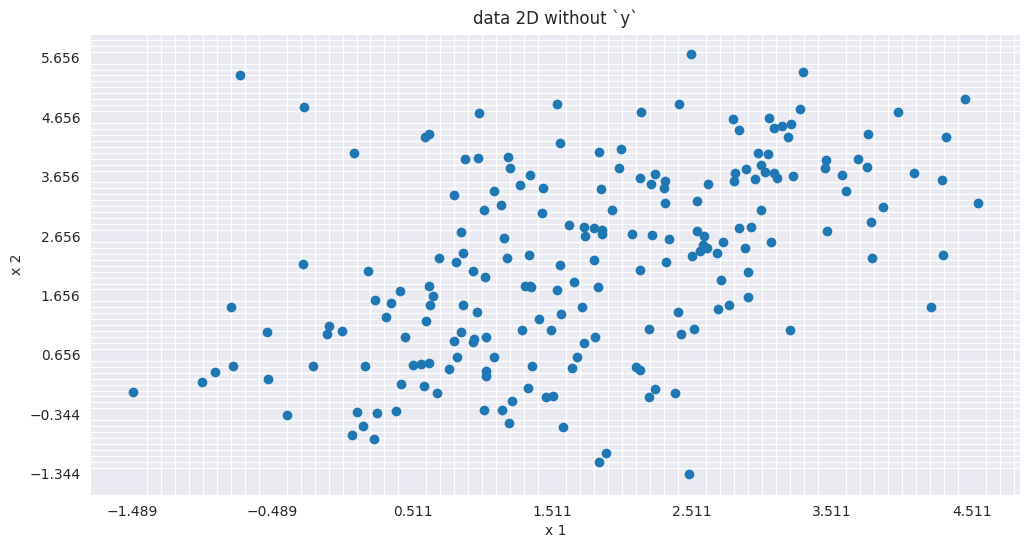

In [454]:
size = (12, 6)
draw_2D_scatter(as_x=data_2d['x1'], as_y=data_2d['x2'], mark=None, title=f'data 2D without `y`', xlabel='x 1', ylabel=f'x 2', figsize=size)

Як бачимо з меж, попередня нормалізація - зайва

## MODEL

- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

##### Розрахуємо для розбиття на кластери від 1 до 11

In [455]:
X = data_2d[['x1', 'x2']].to_numpy()
x = [n_clus for n_clus in range(1, 12)]
kmeans = [KMeans(n_clusters=n_clus, random_state=0, n_init='auto').fit(X) for n_clus in x]

In [456]:
y = [km.inertia_ for km in kmeans]

In [457]:
def draw_2D(as_x: list, as_y: list, title: str, xlabel: str, ylabel: str, figsize: tuple|None=None) -> None:
    size = figsize or (15, 5)
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1, 1, 1)
    major_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x))/len(as_x)) or 1)
    minor_ticks = np.arange(min(as_x), max(as_x)+1, int((max(as_x) - min(as_x))/len(as_x)/10) or 0.1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    major_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y))/len(as_y)) or 1)
    minor_ticks_y = np.arange(min(as_y), max(as_y)+1, int((max(as_y) - min(as_y))/len(as_y)/10) or 0.1)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)

    plt.plot(
             as_x, 
             as_y, 
            #  label=f'2D', 
             color=random.choice('rgbcmyk'), 
             linestyle=random.choice(['-', '--', '-.', ':', None]),
             marker=random.choice('o+xdvs*.^')
             )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    ax.grid(which='both')
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


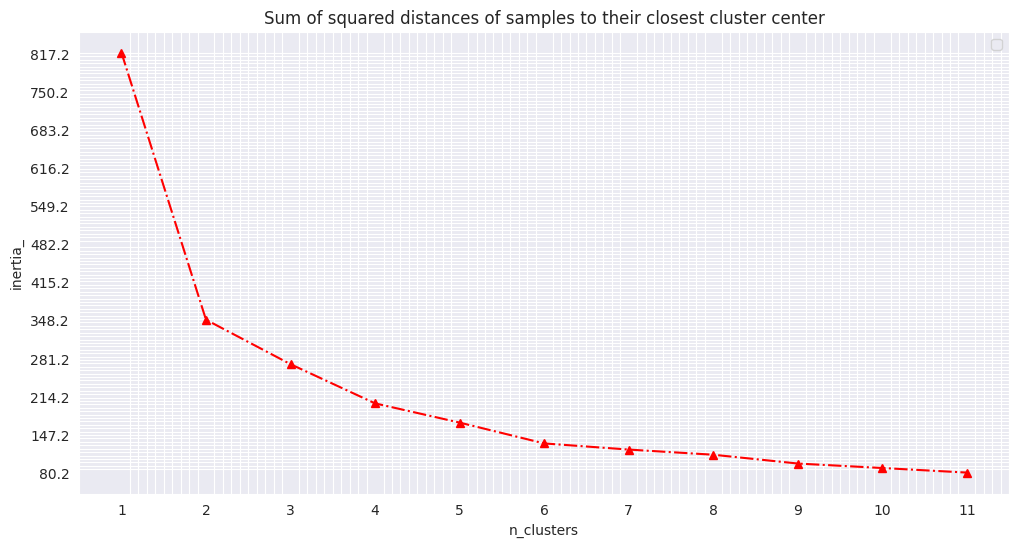

In [458]:
title = 'Sum of squared distances of samples to their closest cluster center'
draw_2D(as_x=x, as_y=y, title=title, xlabel='n_clusters', ylabel=f'inertia_', figsize=(12, 6))

Візуально начебто 2 кластери оптимально, але ...

- https://stackoverflow.com/questions/51762514/find-the-elbow-point-on-an-optimization-curve-with-python
- https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python/13849249#13849249
- https://github.com/arvkevi/kneed

In [459]:
kneedle = KneeLocator(x, y, S=1.0, curve='convex', direction='decreasing')

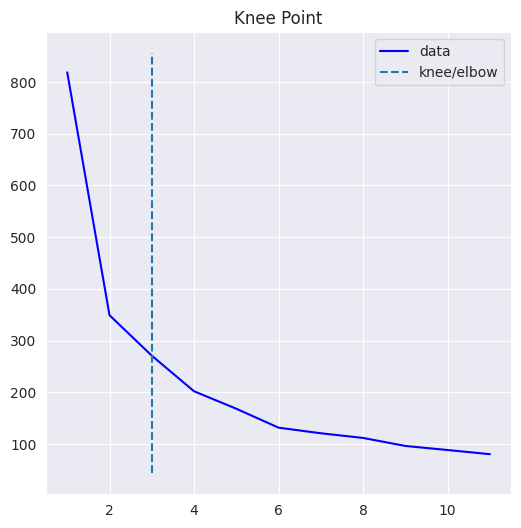

In [460]:
kneedle.plot_knee()

За алгоритмом оптимального значення: кластерів 3, зі значенням (суми) найбільших квадратичних відхилень від центроїдів 270.76

In [461]:
kneedle.knee, kneedle.knee_y

(3, 270.76301490918763)

Відносне зменшення значення найбільших квадратичних відхилень від центроїдів при покрокомому збільшенні кількості кластерів від 1

In [462]:
[(y[el-1]-y[el])/y[el-1] for el in range(len(y)) if el != 0]

[0.5737653082456687,
 0.22409806759241682,
 0.2544183671063389,
 0.16743506444255085,
 0.21781515371328108,
 0.08226000723630648,
 0.07506702535704798,
 0.13883175893527067,
 0.08200447518568296,
 0.09101620656036637]

In [463]:
kmeans[1:3]

[KMeans(n_clusters=2, n_init='auto', random_state=0),
 KMeans(n_clusters=3, n_init='auto', random_state=0)]

##### Якщо взяти з початкових даних перший стовпчик як результат кластеризації (відомий клас)

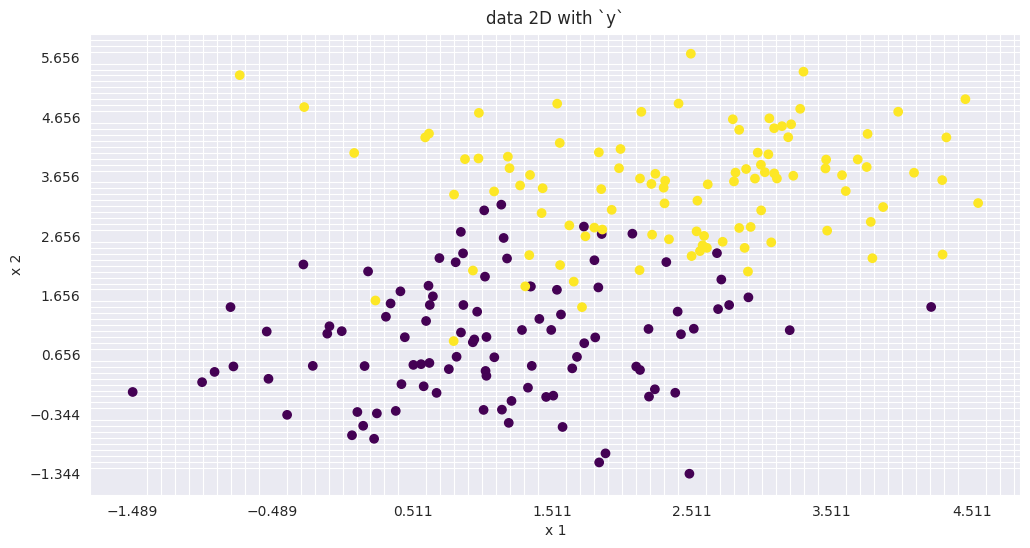

In [464]:
draw_2D_scatter(as_x=data_2d['x1'], as_y=data_2d['x2'], mark=data_2d['y'], title=f'data 2D with `y`', xlabel='x 1', ylabel=f'x 2', figsize=size)

##### Якщо взяти кластеризацію з розбиттям на 2 класи

In [465]:
kmeans[1].labels_

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0], dtype=int32)

In [466]:
kmeans[1].cluster_centers_

array([[2.46540572, 3.48660748],
       [0.97799508, 0.80217417]])

In [467]:
centroids = pd.DataFrame(kmeans[1].cluster_centers_)
centroids.columns = ['x1', 'x2']

In [468]:
centroids

,x1,x2
0,2.465406,3.486607
1,0.977995,0.802174


Додамо результат кластеризації - позначення `y2`

In [469]:
y2 = pd.DataFrame({'y2':kmeans[1].labels_})
data_2d_c = pd.concat([data_2d, y2], axis=1)
data_2d_c.head()

,y,x1,x2,y2
0,0.0,-0.768716,0.460860,1
1,0.0,2.687848,2.366961,0
2,0.0,-0.201379,0.470430,1
3,0.0,0.608496,1.225400,1
4,0.0,-0.082282,1.137218,1


Додамо центроїди

In [470]:
с2 = pd.DataFrame({'y2':[centroids.shape[0]+1, centroids.shape[0]+2]})
с2 = pd.concat([с2, centroids], axis=1)
с2.head()

,y2,x1,x2
0,3,2.465406,3.486607
1,4,0.977995,0.802174


In [471]:
data_2d_c = pd.concat([data_2d_c, с2], axis=0, ignore_index=True)
data_2d_c.tail(3)

,y,x1,x2,y2
199,1.0,3.764228,4.372587,0
200,NaN,2.465406,3.486607,3
201,NaN,0.977995,0.802174,4


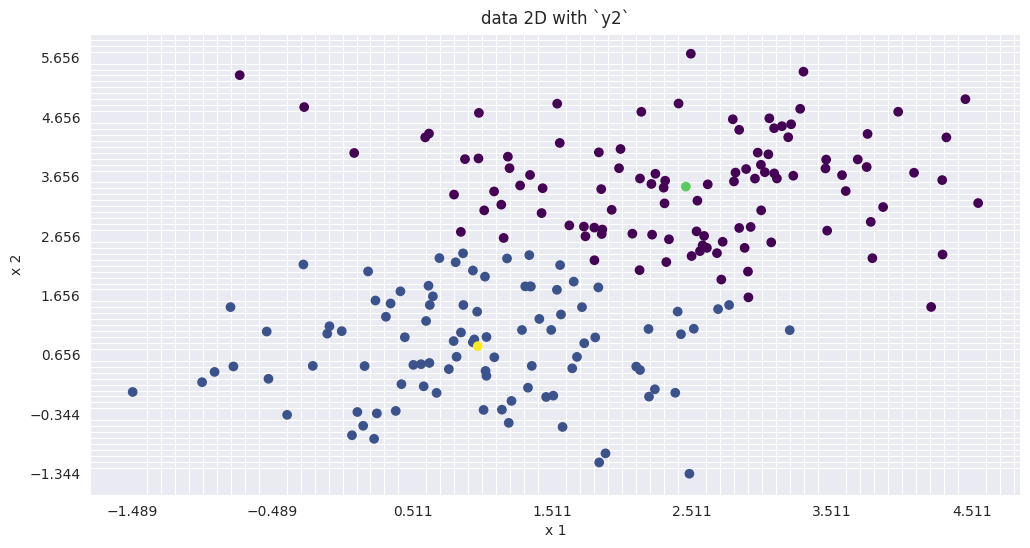

In [472]:
draw_2D_scatter(as_x=data_2d_c['x1'], as_y=data_2d_c['x2'], mark=data_2d_c['y2'], title=f'data 2D with `y2`', xlabel='x 1', ylabel=f'x 2', figsize=size)

##### Якщо взяти з кластеризацію з розбиттям на 3 класи

In [473]:
kmeans[2].labels_

array([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2,
       0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 1, 0, 2, 0,
       2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0], dtype=int32)

In [474]:
kmeans[2].cluster_centers_

array([[2.67513782, 3.99328211],
       [0.74771856, 0.50438896],
       [1.96916569, 2.32414269]])

In [475]:
centroids = pd.DataFrame(kmeans[2].cluster_centers_)
centroids.columns = ['x1', 'x2']

In [476]:
centroids

,x1,x2
0,2.675138,3.993282
1,0.747719,0.504389
2,1.969166,2.324143


Додамо результат кластеризації - позначення `y3` та центроїди

In [477]:
y3 = pd.DataFrame({'y3':kmeans[2].labels_})
data_2d_c = pd.concat([data_2d, y3], axis=1)
с3 = pd.DataFrame({'y3':[centroids.shape[0] + i for i in range(centroids.shape[0])], })
с3 = pd.concat([с3, centroids], axis=1)
data_2d_c = pd.concat([data_2d_c, с3], axis=0, ignore_index=True)
data_2d_c.tail(3)

,y,x1,x2,y3
200,NaN,2.675138,3.993282,3
201,NaN,0.747719,0.504389,4
202,NaN,1.969166,2.324143,5


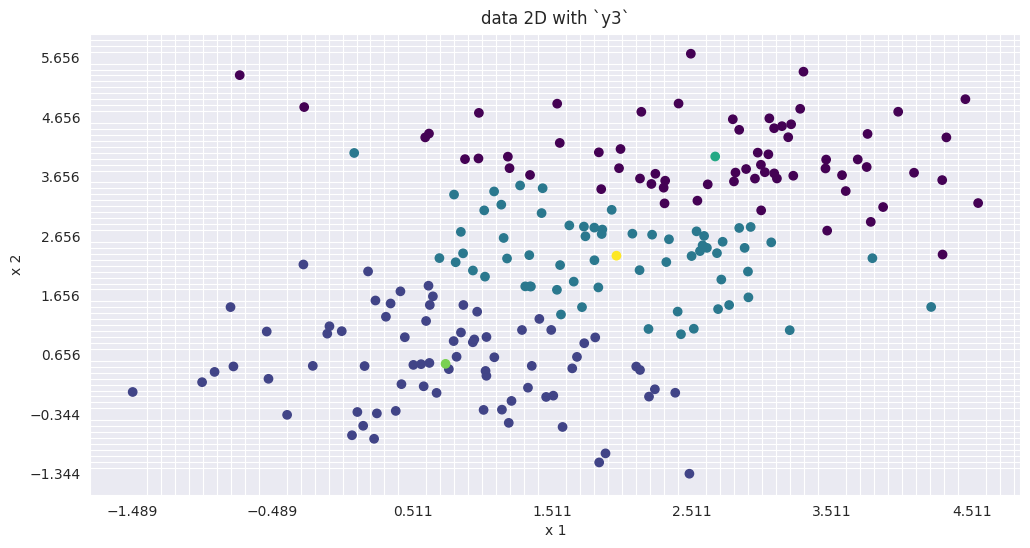

In [478]:
draw_2D_scatter(as_x=data_2d_c['x1'], as_y=data_2d_c['x2'], mark=data_2d_c['y3'], title=f'data 2D with `y3`', xlabel='x 1', ylabel=f'x 2', figsize=size)

## INTERPRET

In [479]:
kmeans[1].predict([[0, 0], [1.5, 1.7], [2.5, 3.6], [2.6, -0.35], [-0.5, 3], [3.5, 0], [0.5, 5]])

array([1, 1, 0, 1, 1, 1, 0], dtype=int32)

In [480]:
kmeans[2].predict([[0, 0], [1.5, 1.7], [2.5, 3.6], [2.6, -0.35], [-0.5, 3], [3.5, 0], [0.5, 5]])

array([1, 2, 0, 1, 2, 2, 0], dtype=int32)

# `mnist`

## SCRUB & EXPLORE

In [481]:
mnist.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x775,x776,x777,x778,x779,x780,x781,x782,x783,x784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## По аналогії з попереднім датасетом, якщо прийняти колонку 0 як відому приналежність до кластерів (0-9)

In [509]:
y = mnist['x0']
df = mnist.drop('x0', axis=1)

Нормалізуємо значення фіч

In [510]:
x_norm = StandardScaler().fit_transform(df)

Зменшимо розмірність за допомогою Principal Component Analysis
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [513]:
x_pca = PCA(n_components=2).fit_transform(x_norm)

 ## Якщо вважати дані з датасету підготовленими

Нормалізуємо значення фіч

In [ ]:
x_norm = StandardScaler().fit_transform(mnist)

Зменшимо розмірність за допомогою Principal Component Analysis

In [ ]:
x_pca = PCA(n_components=2).fit_transform(x_norm)

plt.figure(figsize=(20, 20))

In [495]:
plt.figure(figsize=(40, 40))

<Figure size 4000x4000 with 0 Axes>

<Figure size 4000x4000 with 0 Axes>

<Axes: >

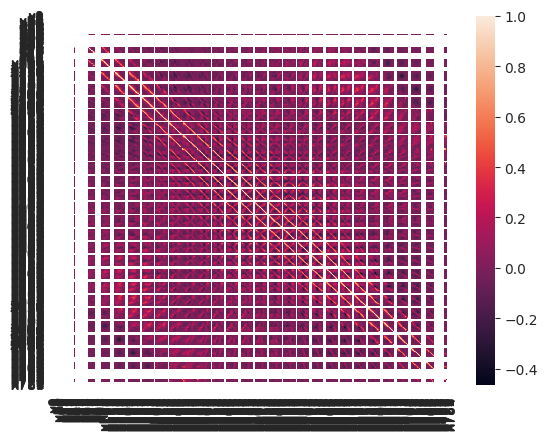

In [496]:
corr = mnist.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [497]:
corr

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x775,x776,x777,x778,x779,x780,x781,x782,x783,x784
x0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.040882,0.040882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# --TEST--- ###############################

In [484]:
from sklearn.cluster import KMeans
import numpy as np

X = np.array([[1, 2], [1, 4], [1, 0],
              [10, 2], [10, 4], [10, 0]])

kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(X)

In [485]:
data_x = pd.DataFrame(X)

In [486]:
data_x.columns = ['c0', 'c1']

Відповідно labels_ - повертає список зі значеннями c(i)c^{(i)}c(i), а cluster_centers_ - це координати центроїдів.

In [487]:
kmeans.labels_

array([1, 1, 1, 0, 0, 0], dtype=int32)

In [488]:
kmeans.predict([[3, 2], [12, 3], [0, 0]])

array([1, 0, 1], dtype=int32)

In [489]:
kmeans.cluster_centers_

array([[10.,  2.],
       [ 1.,  2.]])

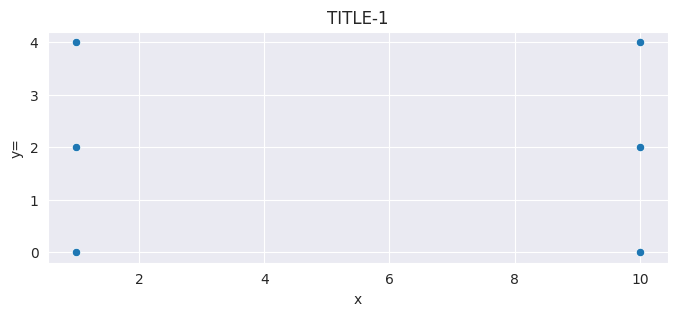

In [490]:
def draw_scatters_sns(df: pd.DataFrame, as_x: list, as_y: list, title: str) -> None:
    plt.figure(figsize=(8, 3))
    sns.set_style('darkgrid')
    [sns.scatterplot(x=x, y=y, data=df) for x, y in zip(as_x, as_y)]
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y=')
    plt.show()

draw_scatters_sns(data_x, as_x=['c0'], as_y=['c1'], title='TITLE-1')

In [491]:
draw_scatters_sns(data_2d, as_x=['c0'], as_y=['y'], title='TITLE-1')

type: Could not interpret value `c0` for parameter `x`

<Figure size 800x300 with 0 Axes>